__Purpose:__ Introduce Personalized Federated Learning, specifically by implementing APFL on our dataset and then trying other methods.
<br>
1. We are still assuming we can test on the second half (updates 10-19ish) since (human/co-adaptive) learning should be complete by then!  For reasons shown in earlier NBs

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

# Testing APFL

In [3]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

Testing the APFL Implementation

In [4]:
user_c0_APFL = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_APFL = Server(1, D_0_7, 'APFL', user_c0_APFL)

global_model_APFL.execute_FL_loop()

In [7]:
big_loop_iters = 2000
for i in range(big_loop_iters):
    global_model_APFL.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL.all_clients:
    print((my_client.current_round, my_client.current_update))

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 355, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 741, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 1066, 150)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 1532, 200)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 1687, 250)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 1973, 300)

(Current Local Round, Current Local Update)
(288, 15)
(315, 16)
(163, 13)
(234, 14)
(315, 16)
(270, 15)
(252, 15)
(217, 14)
(261, 15)
(216, 14)
(261, 15)
(189, 13)
(360, 17)
(261, 15)


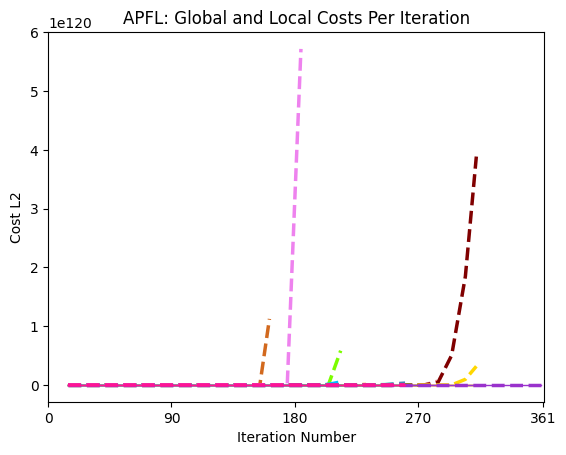

In [8]:
external_plot_error(user_c0_APFL, custom_title='APFL: Global and Local Costs Per Iteration')

In [9]:
external_plot_error_GLOBAL(global_model_APFL, dim_reduc_factor=1, show_update_change=False, custom_title='APFL: Global and Local Costs Per Iteration')

IndexError: list index out of range

In [ ]:
assert(1==0)

# DEVELOPMENT

# Personalized FL Algorithms
ALL PERSONALIZATION ALGORITHMS
1. APFL
1. Cesar/Taha: AFL
1. Cesar/Taha: PersA-FL MAML
1. Cesar/Taha: PersA-FL ME
1. PFA: PP F Adaptation for Effective Model Personalization
1. Pers RT FL for Epileptic Seizure Detection
1. An Efficient Framework for Clustered FL
1. Pers FL with DP
## Adaptive Personalized FL Testing Ground

Adapting their code to actually be able to be run in something other than top-down server-only approach
> Their Github: https://github.com/MLOPTPSU/FedTorch <br>
> APFL link: https://github.com/MLOPTPSU/FedTorch/blob/ab8068dbc96804a5c1a8b898fd115175cfebfe75/fedtorch/comms/trainings/federated/apfl.py#L33

loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. Loss.backward() does not update the weights, only computes the gradients.  The graph is used by loss.backward() to compute gradients.  In pseudo-code: x.grad += dloss/dx

optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:

x += -lr * x.grad
optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

optimizer.zero_grad() and optimizer.step() do not affect the graph of autograd objects. They only touch the model’s parameters and the parameter’s grad attributes.

If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:

loss3 = loss1 + loss2
loss3.backward()

In [ ]:
#python run_mpi.py -f -ft apfl -n 10 -d mnist -lg 0.1 -b 50 -c 20 -k 1.0 -fs local_step -l 10 -r 2 -pa 0.5 -fp
#'--num_epochs': args.num_epochs_per_comm * args.num_comms,

# num_epochs_per_comm=1
# num_clients=20
# batch_size=50
# num_comms=100
# lr_gamma=1.0
# lr_mu = 1

cmd = 'python main.py '
for k, v in training_params.items():
    if v is not None:
        cmd += ' {} {} '.format(k, v)

Reworking their code for us <br> <br>

In [ ]:
#https://github.com/MLOPTPSU/FedTorch/blob/ab8068dbc96804a5c1a8b898fd115175cfebfe75/fedtorch/comms/trainings/federated/apfl.py#L33

def apfl_skeleton(client):
    # Number of communication rounds in federated setting should be defined
    for n_c in range(client.args.num_comms):
        client.args.rounds_comm += 1
        # Configuring the devices for this round of communication
        if client.args.graph.rank in online_clients_server: 
            if client.args.graph.rank in online_clients:
                is_sync = False
                ep = -1 # counting number of epochs
                while not is_sync:
                    ep += 1
                    for i, (_input, _target) in enumerate(client.train_loader):
                        # update local step.
                        # update local index and get local step
                        # adjust learning rate (based on the # of accessed samples)
                        # load data
                        # Skip batches with one sample because of BatchNorm issue in some models!
                        # inference and get current performance.
                        # compute gradient and do local SGD step.
                        # compute gradient and do local SGD step.
                        # update alpha
                        # reset load time for the tracker.
            # Sync the model server based on model_clients
            # evaluate the sync time
            # Do the validation on the server model
            # logging.
            # reset start round time.
            # validate the models at the test data
            
################################################################################################

def train_and_validate_federated_apfl():
    #if client.args.evaluate and client.args.graph.rank==0:
    #    # Do the testing on the server and return
    #    do_validate(client.args, client.model, client.optimizer,  client.criterion, client.metrics, client.test_loader, client.all_clients_group, data_mode='test')
    #    return
    
    tracker = define_local_training_tracker()
    start_global_time = time.time()
    tracker['start_load_time'] = time.time()

    # Number of communication rounds in federated setting should be defined
    # IN THIS CASE, WE NUM_COMMS IS NUM ROUNDS BUT WE COUNT UNAVAILABILITY FOR A ROUND AS A COMM
    # How to change this to the case where the global model controls but the local nodes have their own number of comm rounds?
    # For now I think it's easiest to just use a single shared global num_comms
    for n_c in range(self.num_comms):
        self.current_round += 1
        self.comm_time.append(0.0)  # NEED TO ADD THIS
        # Configuring the devices for this round of communication
        self.set_available_clients_list()
        self.choose_clients()
        # Idk what this is doing, I'm assuming just choosing clients
        #if (n_c == 0) and (0 not in online_clients):
        #    online_clients += [0]
        #online_clients_server = online_clients if 0 in online_clients else online_clients + [0]
        #online_clients_group = dist.new_group(online_clients_server)
        
        # Idk what all this graph rank stuff is
        #if client.args.graph.rank in online_clients_server: 
        for my_client in self.chosen_clients_lst:
            #client.model_server = distribute_model_server(client.model_server, online_clients_group, src=0)
            # This is what the above line does, broadcasts params to the client model... what params?
            #    for server_param in model_server.parameters():
            #          dist.broadcast(server_param.data, src=src, group=group)
            #my_client. ?? recieve new global model? Other params?
            # Maybe I could combine these into a dictionary to pass down instead of doing this manually
            my_client.global_method = self.method
            my_client.global_w = self.w
            
            # Now load condition num for us I think, or general client init stuff
            #client.model.load_state_dict(client.model_server.state_dict())
            #
            
            #if client.args.graph.rank in online_clients:
            if True:  # Not sure how the above condition is different from my existing for loop above 
                is_sync = False
                # Client's epoch? Does it matter?
                ep = -1 # counting number of epochs
                while not is_sync:
                    ep += 1
                    #self.training_data
                    #self.labels
                    # Slice up training-data and labels using my already written code:
                    #my_client.data_stream='streaming'  # This should be set in the client inits already
                    my_client.simulate_data_stream()
                    _input = self.F
                    _target = self.V
                    
                    # What data are we looping through? Could this be our updates? I don't think we want to do all updates on 1 comm tho...
                    # Assuming this is some SGD stochastic data batch stuff
                    #for i, (_input, _target) in enumerate(client.train_loader):
                    for i in range(1):
                        my_client.train_model
                        # update local step.
                        logging_load_time(tracker)  # NEED TO ADD THIS
                        # update local index and get local step
                        # ^ How is local index different from local round?
                        
                        #client.args.local_index += 1
                        my_client.local_round += 1
                        # Yah this is some stochastic batching stuff... ask Momona if we should be doing this
                        #client.args.local_data_seen += len(_target)
                        #get_current_epoch(client.args)
                        # This code is the above function... I don't think we are doing epochs?
                        #if args.growing_batch_size:
                        #    args.epoch_ = args.local_data_seen / args.num_samples_per_epoch
                        #else:
                        #    args.epoch_ = args.local_index / args.num_batches_train_per_device_per_epoch
                        #args.epoch = int(args.epoch_)
                        
                        # I don't have a decaying learning rate yet
                        #local_step = get_current_local_step(client.args)
                        #"""Design a specific local step adjustment scheme based on lr_decay_by_epoch"""
                        #try:
                        #    return args.local_steps[args.epoch]
                        #except:
                        #    return args.local_steps[-1]
                        
                        # adjust learning rate (based on the # of accessed samples)
                        #lr = adjust_learning_rate(client.args, client.optimizer, client.scheduler)
                        # What is lr_external? The global one or a default val?
                        # Whose lr is this? The client's or the server's?
                        if lr_external is None:
                            # Don't have a scheduler since no epochs
                            lr = lr_scheduler(epoch_)
                            if lr is None:
                                lr = lr_prev
                        else:
                            lr = lr_external
                        if lr_prev != lr:
                            lr_prev = lr

                        # load data
                        # """Loads a mini-batch and records the loading time."""
                        #_input, _target = load_data_batch(client.args, _input, _target, tracker)
                        
                        # Doesn't apply to us I don't think
                        # Skip batches with one sample because of BatchNorm issue in some models!
                        #if _input.size(0)==1:
                        #    is_sync = is_sync_fed(client.args)
                        #    break
                        
                        # inference and get current performance.
                        # zero_grad just returns a deepcopy of self.model... not sure if this is different from our self.w? It sets self.grad to deepcopy(self.model)
                        # ^ Should this be self.w or the cost func?
                        # So does this even do anything then? If I did self.w = self.w... so it must be something else...
                        client.optimizer.zero_grad()
                        loss, performance = inference(client.model, client.criterion, client.metrics, _input, _target)
                        # compute gradient and do local SGD step.
                        loss.backward()
                        client.optimizer.step(apply_lr=True,apply_in_momentum=client.args.in_momentum, apply_out_momentum=False)
                        client.optimizer.zero_grad()
                        client.optimizer_personal.zero_grad()
                        loss_personal, performance_personal = inference_personal(client.model_personal, client.model, 
                                                                                 client.args.fed_personal_alpha, client.criterion, 
                                                                                 client.metrics, _input, _target)
                        # compute gradient and do local SGD step.
                        loss_personal.backward()
                        client.optimizer_personal.step(apply_lr=True,apply_in_momentum=client.args.in_momentum, apply_out_momentum=False)
                        # update alpha
                        if client.args.fed_adaptive_alpha and i==0 and ep==0:
                            client.args.fed_personal_alpha = alpha_update(client.model, client.model_personal, client.args.fed_personal_alpha, lr) #0.1/np.sqrt(1+args.local_index))
                            average_alpha = client.args.fed_personal_alpha
                            average_alpha = global_average(average_alpha, client.args.graph.n_nodes, group=online_clients_group)
                            log("New alpha is:{}".format(average_alpha.item()), client.args.debug)
                        # reset load time for the tracker.
                        tracker['start_load_time'] = time.time()
                        is_sync = is_sync_fed(client.args)
                        if is_sync:
                            break
            else:
                log("Offline in this round. Waiting on others to finish!", client.args.debug)

            do_validate(client.args, client.model, client.optimizer_personal, client.criterion, client.metrics, 
                        client.train_loader, online_clients_group, data_mode='train', personal=True, 
                        model_personal=client.model_personal, alpha=client.args.fed_personal_alpha)
            if client.args.fed_personal:
                do_validate(client.args, client.model, client.optimizer_personal, client.criterion, client.metrics, 
                            client.val_loader, online_clients_group, data_mode='validation', personal=True, 
                            model_personal=client.model_personal, alpha=client.args.fed_personal_alpha)

            # Sync the model server based on model_clients
            tracker['start_sync_time'] = time.time()
            client.args.global_index += 1
            client.model_server = fedavg_aggregation(client.args, client.model_server, client.model, 
                                                     online_clients_group, online_clients, client.optimizer)
            # evaluate the sync time
            logging_sync_time(tracker)
            # Do the validation on the server model
            do_validate(client.args, client.model_server, client.optimizer, client.criterion, client.metrics, 
                        client.train_loader, online_clients_group, data_mode='train')
            if client.args.fed_personal:
                do_validate(client.args, client.model_server, client.optimizer, client.criterion, client.metrics, 
                            client.val_loader, online_clients_group, data_mode='validation')
            # logging.
            logging_globally(tracker, start_global_time)
            # reset start round time.
            start_global_time = time.time()
            # validate the models at the test data
            if client.args.fed_personal_test:
                do_validate(client.args, client.model_client, client.optimizer_personal, client.criterion, 
                            client.metrics, client.test_loader, online_clients_group, data_mode='test', personal=True,
                            model_personal=client.model_personal, alpha=client.args.fed_personal_alpha)
            elif client.args.graph.rank == 0:
                do_validate(client.args, client.model_server, client.optimizer, client.criterion, 
                            client.metrics, client.test_loader, online_clients_group, data_mode='test')
        else:
            log("Offline in this round. Waiting on others to finish!", client.args.debug)
        dist.barrier(group=client.all_clients_group)            log("Offline in this round. Waiting on others to finish!", client.args.debug)
        dist.barrier(group=client.all_clients_group)

My original attempts at writing

In [ ]:
# Remember to set smoothbatch='off'

In [ ]:
define T somewhere... probably just need to edit it since that will be how many times execute_fl will be called...

for t in range(T):
    running_dec_aggr = 0
    # They wrote: "if t not devices Tau then" but that seem like it would only run 1 update per t, 
    # AKA 50 t's to select new clients.  I'll write it like they did ig...
    if t%num_steps!=0:
        #for i in range(tau):  # DEFINE tau
        for my_client in self.chosen_clients_lst:
            # This checks updates, handles streaming, and sets FVD
            #my_client.simulate_data_stream(streaming_method='streaming')
            
            mu = my_client.alpha_D
            L = np.linalg.norm(( my_client.F*np.tranpose(my_client.F) + my_client.alpha_D))
            kappa = L/mu
            a = np.max(128*kappa, tau)
            eta_t = 16 / (mu*(t+a))
            my_client.p.append((t+a)**2)

            #my_client.global_w -= my_client.eta * grad(f_i(my_client.global_w; my_client.smallChi))
            my_client.global_w -= eta_t * my_client.gradient_cost_l2(my_client.F, self.global_w, my_client.H, my_client.V, my_client.learning_batch, my_client.alphaF, my_client.alphaD)
            #my_client.local_w -= my_client.eta * grad_v(f_i(my_client.v_bar; my_client.smallChi))
            my_client.local_w -= eta_t * my_client.gradient_cost_l2(my_client.F, my_client.mixed_w, my_client.H, my_client.V, my_client.learning_batch, my_client.alphaF, my_client.alphaD)
            my_client.mixed_w = my_client.adap_alpha*my_client.local_w - (1 - my_client.adap_alpha) * my_client.global_w
        for my_client in list(set(self.available_clients_lst) ^ set(self.chosen_clients_lst)):
            # Otherwise indices will break when calculating finalized running terms
            my_client.p.append(my_client.p[-1])
    else:
        running_global_dec = 0
        for my_client in self.chosen_clients_lst:
            running_global_dec += my_client.global_w
        self.w = copy.copy(running_global_dec)
        self.choose_clients()
        # Presumably len(self.chosen_clients_lst) will always be the same (same C)... otherwise would need to re-set K
        for my_client in self.chosen_clients_lst:
            my_client.global_w = copy.copy(self.w)  # Does this need to be a copy?  Depends if it gets updated or overwritten...
    self.w = (1/K)*running_dec_aggr
    #^ Should this be self.global_w? Just have to make it consistent everywhere
    # This is the global model's dec, so I'll leave it as is.  No reason for the global model to have a local dec too...

    # The purpose of this is to update the current weight to just be the same as last iter
    # My code doesn't track history so I don't need to do it, for now at least
    #for my_client in (set(self.available_clients_lst) ^ set(self.chosen_clients_lst)):  # Symmetric Difference for sets
    #    my_client.local_w = my_client.local_w

# Defining params used in the next section
for t in range(T):
    summed_chosen_globals = np.sum([chosen_client.global_w for chosen_client in self.chosen_clients_lst])
    for my_client in self.available_clients_lst:
        my_client.running_pers_term += my_client.p[t]*(my_client.adap_alpha*my_client.local_w + (1-my_client.adap_alpha)*(1/K)*summed_chosen_globals)
        my_client.running_global_term += my_client.p[t]*summed_chosen_globals

# The actual models                                                    
# "tin for i=1,...,n"
for my_client in self.available_clients_lst:
    S_T = np.sum(my_client.p)
    # All these random params are defined in theorem 2 on Page 10
    # "Output" --> lol and do what with
    # Personalized model: v^hat AKA personalized_w = (1/S_T)*\sum_1^T(p_t(alpha_i*v_i^t + (1-alpha_i)*(1/K)*(\sum_{j in chosen clients} w_j^t)))
    my_client.final_personalized_w = (1/S_T)*my_client.running_pers_term
    # Global model: w^hat = 1/(K*S_T)*(\sum_1^T p_t*(\sum_j w_j^t))
    my_client.final_global_w = (1/K*S_T)*my_client.running_global_term


In [ ]:
# Finding the optimal alpha
# a_i* = argmin_{a_i exists in [0,1]} f_i(a_i*v + (1-a_i)w)
a_i(t) = a_i(t-1) - eta_t grad_a(v_bar_i^(t-1); zeta_t)

## Personalized Asynchronous Federated Learning (Taha+Cesar)
> https://arxiv.org/pdf/2210.01176.pdf

In [ ]:
assert(1==0)

Basic AFL
> My code is not configured to run this way, although this way is the most realistic (server waits for client responses).  Ideally would have some way to weight different clients if there are some that are spamming, or generally just faster than others and contributing more.

In [ ]:
# Repeat until converged...
# how do you know in a decentralized way lol
#if self.update_recieved:
#    self.w -= self.beta*self.latest_update

Personalized AFL
> 3 Methods (1 is just vanilla AFL)

In [ ]:
#input: number of local steps Q, local stepsize η, MAML stepsize α, Moreau Envelope (ME) regularization parameter λ, minimum batch size b, estimation error ν.

# Do client selection

for my_client in self.chosen_clients_lst:
    my_client.global_w = self.w
    for q in range(Q):
        #"Sample a data batch D_{i, q} from distribution p_i"
        
        # OPTION A (AFL) --> Just what is shown in the cell above
        if self.global_method=='AFL':
            # Server doesn't have client's grad input info... eg FDHV
            # In their model/code, does the client send the params or the new weight?
            
            # Eqn 5 is the original
            # Eqn 9 is the biased estimation of 5, shown below
            self.w -= self.eta*gradient_cost_l2(self.F,self.D,self.H,self.V,self.learning_batch,self.alphaF,self.alphaD)
        # OPTION B (PersA-FL: MAML)
        elif self.global_method=='PersA_FL_MAML':
            #"Sample 2 databatches from distribution p_i"
            # I have no idea what these terms are lol
            # I don't think I can use the analytical cost funcs here either now
            self.w -= self.eta*(I-alpha*Hessian(self.w, D_dd))*grad(self.w-alpha*grad(D_d), D)
        # OPTION C (PersA-FL: ME)
        elif self.global_method=='PersA_FL_ME':
            self.h = f(theta_i, D) + lambda*0.5*(np.linalg.norm(theta_i - self.w)^2)
            #"Minimize h wrt theta_i up to accuracy level v to find theta_tilde_i"
            #np.linalg.norm(grad_h(theta_tilde_i(self.w), self.w, D)) <= v
            #scipy.minimize(...)
            self.w -= self.eta*lambda*(self.w - theta_tilde_i(self.w))
        
        # ELSE
        else:
            print(f'Global method {self.method} not defined, please select one from the following: {self.implemented_global_training_methods}')
delta_i = self.w_i_0 - self.w_i_Q
# client i broadcasts delta_i to the server
#"Repeat until not interrupted by the server"